In [1]:
import jax.numpy as np
from nrmifactors.postprocess import dissipative_lie_rattle, ralm
from jax import grad, random, scipy
key = random.PRNGKey(seed=1000)

from jax.ops import index, index_update

import matplotlib.pyplot as plt


from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from jax.scipy.linalg import expm

In [3]:
# test dissipative lie rattle

A = random.uniform(key, shape=(20, 20), dtype=np.float64)
A, R = scipy.linalg.qr(A)

if np.linalg.det(A) < 0.:
    A = np.hstack((-A[:, 0].reshape(-1, 1), A[:, 1:]))

print(np.linalg.det(A))

1.0000000000000013


In [4]:
def project_on_sl_algebra(grad_eval, x):
    """Evaluates \sum_i (Tr(grad_f(x) * x * t_i) * t_i where {t_i} is a set
    of generators of the lie group, for the specific case of SL(n)"""
    gx = grad_eval @ x
    diag_gx = np.diag(gx)
    out = (gx - np.diag(diag_gx)).T
    diag_out = np.zeros(out.shape[0])
    for i in range(out.shape[0] - 1):
        curr = np.zeros_like(diag_out)
        curr = index_update(
            curr, index[i:i+2], 
            np.array([diag_gx[i] - diag_gx[i+1], -diag_gx[i] + diag_gx[i+1]]))
        diag_out += curr
    return out + np.diag(diag_out)

In [5]:
obj_func = lambda x: np.trace(np.dot((A - x).T, (A - x)))
grad_f = grad(obj_func)

mu = 0.9
stepsize = 0.01

x0 = np.eye(A.shape[0], dtype=np.float64)
curr_x = x0
curr_y = np.zeros(x0.shape)
grad_eval = grad_f(curr_x).T
chi = np.cosh(-np.log(mu))

In [6]:
curr_x = dissipative_lie_rattle(obj_func, grad_f, x0, 0.9, 0.1, 1e-4, maxiter=5000)

breaking at 99, f_eval: 1.530357147358347e-07


In [7]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions 

xgrid = np.linspace(-10, 10, 500)
delta = xgrid[1] - xgrid[0]

M = np.array([[0.75, 0.25, 0.0,  0.0],
              [0.25, 0.75, 0.0, 0.0],
              [0.0, 0.0, 0.6, 0.4],
             [0.0, 0.0, 0.4, 0.6]])

means = np.array([-7.5, -3.0, 3.0, 7.5])
component_dens = np.array([
    tfd.Normal(m, 1.0).prob(xgrid) for m in means])

lam = np.array([
    np.ones(4) / 4,
    [0.5, 0.5, 0.0, 0.0],
    [0.5, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.5, 0.5],
    [0.0, 0.0, 0.2, 0.8]
])

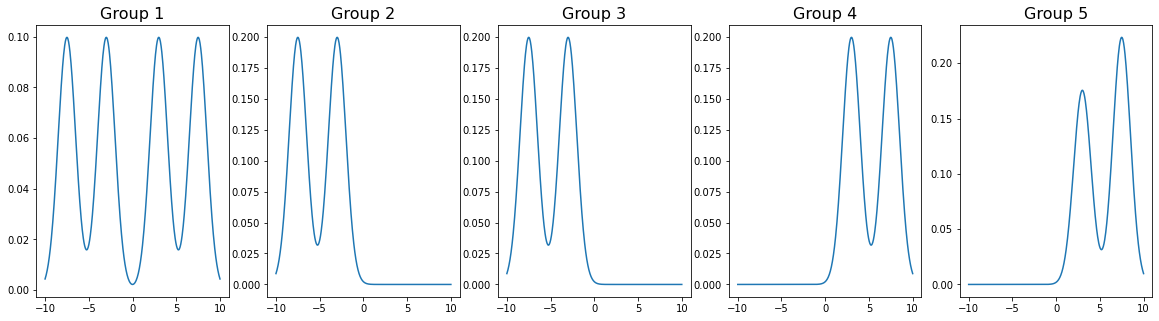

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=lam.shape[0], figsize=(20, 5))


for i in range(lam.shape[0]):
    axes[i].plot(xgrid,  lam[i, :] @ (M @ component_dens))
    axes[i].set_title("Group {0}".format(i+1), fontsize=16)
    
# plt.savefig("postprocess_test/data_dens.pdf", bbox_inches="tight")

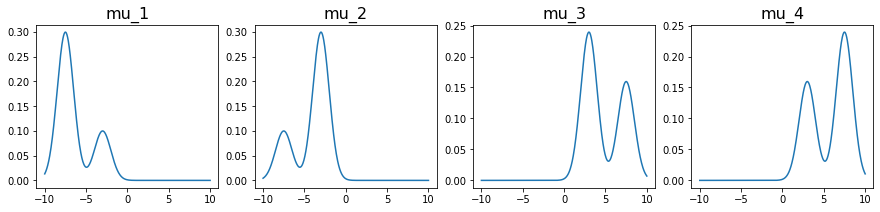

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
# plt.savefig("postprocess_test/orig_mu.pdf", bbox_inches="tight")

In [10]:
def obj_func(x):
    curr_m = x @ M
    trans_dens = curr_m @ component_dens
    trans_dens /= (np.sum(trans_dens, axis=1, keepdims=True) * delta)
    out = 0.0
    for i in range(trans_dens.shape[0]):
        for j in range(i):
            curr = (np.sum((trans_dens[i, :] * trans_dens[j, :])) * delta)**2  
            out += curr
            # print("i: {0}, j: {1}, curr: {2}".format(i, j, curr))
    return out


def constraints(x):
    return - np.concatenate([
        (lam @ np.linalg.inv(x)).reshape(-1, 1),
        (x @ M).reshape(-1, 1)])[:, 0]

def max0(x):
    return x * (x > 0)

def penalty(x, lambdas):
    return 0.5 * 1.0 * np.sum(max0(lambdas / 0.5 + constraints(x))**2)

In [11]:
grad_f = grad(obj_func)
f = obj_func

In [12]:
x0 = np.eye(M.shape[0])

In [13]:
from nrmifactors.postprocess import dissipative_lie_rattle_fast

opt_x, niter = dissipative_lie_rattle_fast(f, grad_f, x0, 0.9, 0.1, 1e-6, maxiter=1000)
opt_x

DeviceArray([[ 1.00839195e+00, -4.21668821e-01, -2.97917815e-02,
               1.28926699e-02],
             [-3.71634872e-01,  1.48344093e+00, -1.11160912e-01,
              -3.34660791e-02],
             [ 1.39742359e-03,  1.64429148e-02,  8.38091786e-01,
              -6.85249196e-01],
             [-7.11776077e-03,  7.01045510e-02, -6.05810375e-01,
               1.37699706e+00]], dtype=float64)

In [14]:

# opt_x = dissipative_lie_rattle(f, grad_f, x0, 0.9, 0.1, 1e-6, maxiter=1000)
# opt_x

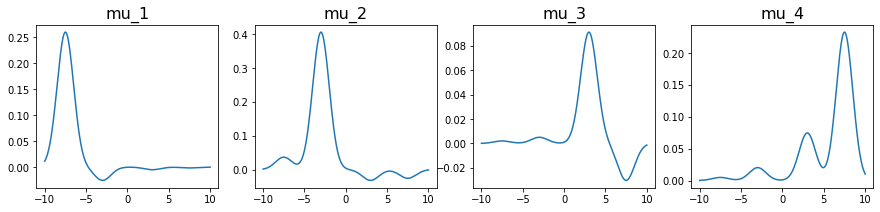

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (q @ M @ component_dens)[j, :])
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
#plt.savefig("postprocess_test/opt_mu_unconstrained.pdf", bbox_inches="tight")

In [16]:
from jax import jacfwd

constr_eval = constraints(x0)
grad_cons = jacfwd(constraints)

mu = 0.9
stepsize = 0.01
init_thr = 1e-2
target_thr = 1e-5
init_lambdas = np.zeros_like(constr_eval) + 1.0
min_lambda = 1e-4
max_lambda = 50
init_rho = 10
dmin = 1e-4


opt_x_pen = ralm(
    obj_func, grad_f, constraints, grad_cons, opt_x, mu, stepsize, 
    init_thr, target_thr, init_lambdas, min_lambda, max_lambda, 
    init_rho, dmin, maxiter=10)

Init Loss:  2.6996443930003844e-13


In [17]:
opt_x_pen

DeviceArray([[ 0.96921763, -0.30102   ,  0.02893356, -0.02833338],
             [-0.24133287,  0.70277817, -0.02219315,  0.02202162],
             [-0.0051236 ,  0.00500688,  1.74346345, -1.16257695],
             [ 0.00402518, -0.00404286, -1.13426825,  1.69881515]],            dtype=float64)

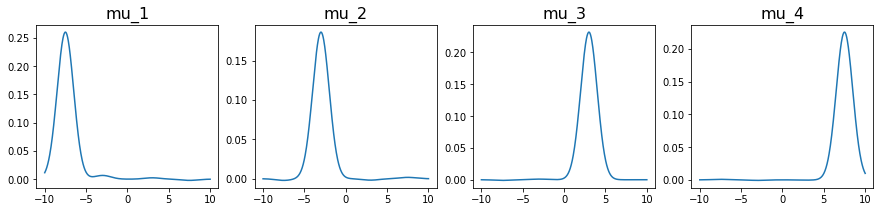

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=M.shape[0], figsize=(15,3))

q = opt_x_pen

for j in range(M.shape[0]):
    axes[j].plot(xgrid,  (q @ M @ component_dens)[j, :])
    
    axes[j].set_title("mu_{0}".format(j+1), fontsize=16)
    
# plt.savefig("postprocess_test/opt_mu_constrained.pdf", bbox_inches="tight")

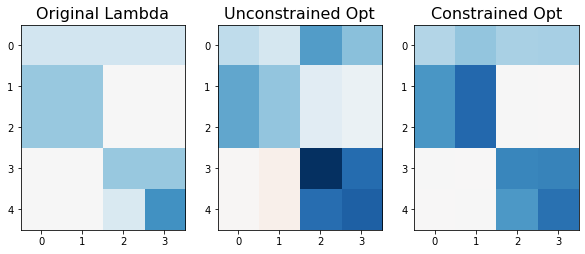

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))

l1 = lam
l2 = lam @ np.linalg.inv(opt_x)
l3 = lam @ np.linalg.inv(opt_x_pen
                        )
vmax = np.max(np.stack([l1, l2, l3]))
vmin = -vmax

axes[0].imshow(l1, cmap="RdBu", vmin=vmin, vmax=vmax)
axes[0].set_title("Original Lambda", fontsize=16)

axes[1].imshow(l2, cmap="RdBu", vmin=vmin, vmax=vmax)
axes[1].set_title("Unconstrained Opt", fontsize=16)

axes[2].imshow(l3, cmap="RdBu", vmin=vmin, vmax=vmax)
axes[2].set_title("Constrained Opt", fontsize=16)

# plt.savefig("postprocess_test/lambdas.pdf", bbox_inches="tight")

plt.show()